In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Set the matplotlib output to svg
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')

import os
# check for set environment variable JB_NOSHOW
show = True
if 'JB_NOSHOW' in os.environ:
    show = False

# Computational Fluid Dynamics

## Overview

The very general approach to numericaly solve a set of coupled PDEs is outlined in {numref}`fig-cfd-overview`. In case of fluid dynamics, these are the equations introduced earlier. The numerical solution of those is called computational fluid dynamics (CFD).

:::{figure-md} fig-cfd-overview

<img src="./figs/numerical_solution_overview.svg" width="100%">

Overview of the general approach in computational fluid dynamics.
:::

The main aspect in solving PDEs is to approximate the involved derivatives. This approximation is carried out in a discretised domain and leads to a set of algebraic equations, eventually a system of linear equations. There exist multiple approximation approaches with different specialisations and properties, where these three are the most prominent ones:

* [Finite element method (FEM)](https://en.wikipedia.org/wiki/Finite_element_method)
* [Finite volume method (FVM)](https://en.wikipedia.org/wiki/Finite_volume_method)
* [Finite difference method (FDM)](https://en.wikipedia.org/wiki/Finite_difference_method)

As FDS is a FDM based solver, the main focus of this section is on the finite difference method. Yet, there will be also a few selected FVM aspects outlined.  

## Approximation of Derivatives

### Taylor Series

The [Taylor series](https://en.wikipedia.org/wiki/Taylor_series) can approximate any $\mf C^\infty$ function at an expansion point $\mf x_0$. The approximation of $\mf f(x)$ is given in terms of $\mf h$, being the coordinate variable in the vicinity of $\mf x_0$.

$$
\begin{align}
\mf f(x_0 + h) &=\mf \sum_{i=0}^{\infty}\frac{1}{i!}\left.\frac{d^if}{dx^i}\right|_{x_0}\cdot h^i \\ 
\mf &=\mf f(x_0) + f'(x_0)\cdot h + \frac{1}{2} f''(x_0)\cdot h^2 + \frac{1}{6}f'''(x_0)\cdot h^3 + \cdots
\end{align}
$$ (eq-taylor-series)

```{margin} Big O notation
The [big O notation](https://en.wikipedia.org/wiki/Big_O_notation) $\mf \mathcal{O}$ indicates the asymptotical behaviour of a function. In the approximation of derivatives, shown in this section, it indicates the functional reduction of the approximation error for $\mf h \rightarrow 0$.
```

In practice, the expansion is aborted at a given order $\mf \mathcal{O}(h^n)$, where $\mf n$ indicates the number of Taylor terms considered, i.e. 

$$
\mf f(x_0 + h) =\sum_{i=0}^{n-1}\left(\frac{1}{i!}\left.\frac{d^if}{dx^i}\right|_{x_0}\cdot h^i\right) +  \mathcal{O}(h^n)\quad .
$$ (eq-taylor-series-n)

The expansion up to order three $\mf \mathcal{O}(h^3)$ takes following form

$$
\mf f(x_0 + h) = f(x_0) + f'(x_0)\cdot h + \frac{1}{2} f''(x_0)\cdot h^2 + \mathcal{O}(h^3)\quad .
$$ (eq-taylor-3rd)

**Example of a Taylor expansion**

As an example, the approximation of the function

$$
\mf f(x) = \frac{x}{10} + \frac{1}{1+x^2}
$$ (eq-cfd-example-fnk)

at the evaluation point $\mf x_0 = 2.0$.

In [2]:
# definition of the example function and its analytical derivatives
def fnk(x, derivative=0):
    if derivative == 1:
        return 0.1 - 2*x * (1+x**2)**(-2)
    if derivative == 2:
        return -2 * (1+x**2)**(-2) + 8*x**2 * (1+x**2)**(-3)
    if derivative == 3:
        return 8*x * (1+x**2)**(-3) + 16*x * (1+x**2)**(-3) - 48*x**3 * (1+x**2)**(-4)
    if derivative > 3:
        return None
    return 0.1*x + (1+x**2)**(-1)

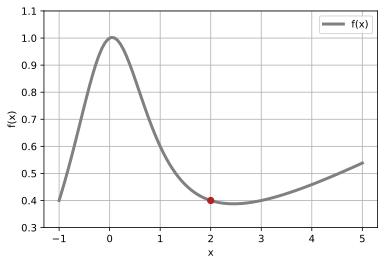

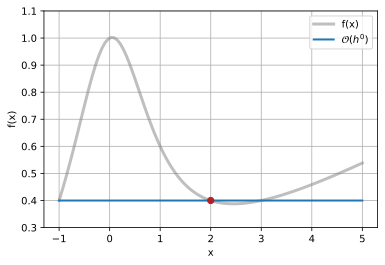

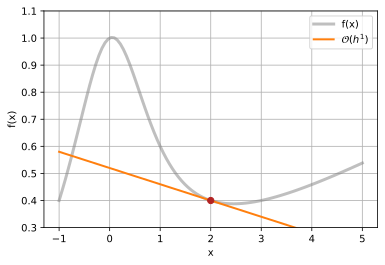

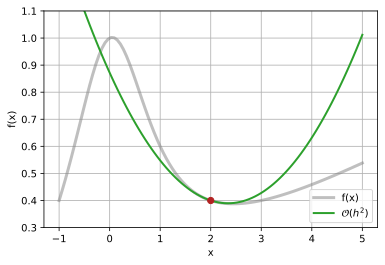

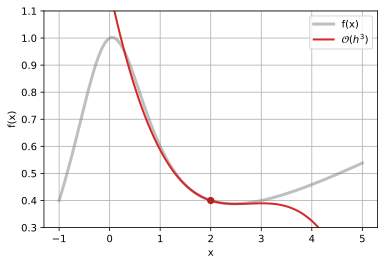

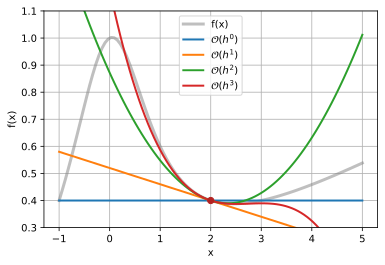

<Figure size 432x288 with 0 Axes>

In [3]:
# set interval for x
xb = -1
xe = 5
# range of x values
x = np.linspace(xb, xe, 100)
f = fnk(x)

# evaluation point
x0 = 2.0

# derivative values at x0
f0p0 = fnk(x0, derivative=0)
f0p1 = fnk(x0, derivative=1)
f0p2 = fnk(x0, derivative=2)
f0p3 = fnk(x0, derivative=3)

# Taylor series for different orders
ts0 =             f0p0 * (x-x0)**0
ts1 = ts0 +       f0p1 * (x-x0)**1
ts2 = ts1 + 1/2 * f0p2 * (x-x0)**2
ts3 = ts2 + 1/6 * f0p3 * (x-x0)**3

# plot generation
alpha = 0.5
ylim = [0.3, 1.1]

plt.plot(x, f, lw=3, color='grey', label='f(x)')
plt.scatter(x0, f0p0, s=40, color='firebrick', zorder=3)
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ylim)
plt.savefig('./figs/taylor_fnk.svg')
if show: plt.show()
plt.clf()

plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='f(x)')
plt.plot(x, ts0, lw=2, color='C0', label='$\mathcal{O}(h^0)$')
plt.scatter(x0, f0p0, s=40, color='firebrick', zorder=3)
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ylim)
plt.savefig('./figs/taylor_ts0.svg')
if show: plt.show()
plt.clf()

plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='f(x)')
plt.plot(x, ts1, lw=2, color='C1', label='$\mathcal{O}(h^1)$')
plt.scatter(x0, f0p0, s=40, color='firebrick', zorder=3)
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ylim)
plt.savefig('./figs/taylor_ts1.svg')
if show: plt.show()
plt.clf()

plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='f(x)')
plt.plot(x, ts2, lw=2, color='C2', label='$\mathcal{O}(h^2)$')
plt.scatter(x0, f0p0, s=40, color='firebrick', zorder=3)
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ylim)
plt.savefig('./figs/taylor_ts2.svg')
if show: plt.show()
plt.clf()

plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='f(x)')
plt.plot(x, ts3, lw=2, color='C3', label='$\mathcal{O}(h^3)$')
plt.scatter(x0, f0p0, s=40, color='firebrick', zorder=3)
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ylim)
plt.savefig('./figs/taylor_ts3.svg')
if show: plt.show()
plt.clf()

plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='f(x)')
plt.plot(x, ts0, lw=2, color='C0', label='$\mathcal{O}(h^0)$')
plt.plot(x, ts1, lw=2, color='C1', label='$\mathcal{O}(h^1)$')
plt.plot(x, ts2, lw=2, color='C2', label='$\mathcal{O}(h^2)$')
plt.plot(x, ts3, lw=2, color='C3', label='$\mathcal{O}(h^3)$')
plt.scatter(x0, f0p0, s=40, color='firebrick', zorder=3)
plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ylim)
plt.savefig('./figs/taylor_all.svg')
if show: plt.show()
plt.clf()

The following figures illustrate the according Taylor approximations for up to $\mf n=3$.

````{tab-set}
```{tab-item} f(x)
<img src="./figs/taylor_fnk.svg" width="90%" />
```

```{tab-item} n=0
<img src="./figs/taylor_ts0.svg" width="90%" />
```

```{tab-item} n=1
<img src="./figs/taylor_ts1.svg" width="90%" />
```

```{tab-item} n=2
<img src="./figs/taylor_ts2.svg" width="90%" />
```

```{tab-item} n=3
<img src="./figs/taylor_ts3.svg" width="90%" />
```

```{tab-item} n in [0,...,3]
<img src="./figs/taylor_all.svg" width="90%" />
```
````

### Derivatives

To approximate the first derivative of a function $\mf f(x)$ at $\mf x=x_0$, i.e. $\mf f'(x_0)$, the Taylor expansion up to $\mf n=2$ can be used

$$
\mf f(x_0 + h) = f(x_0) + f'(x_0)h + \mathcal{O}(h^2)\quad .
$$ (eq-fdm-taylor-n2)

After rearrangemet, this results in the forward differentiation of first order

$$
\mf f'(x_0) = \frac{f(x_0 + h) - f(x_0)}{h} + \mathcal{O}(h)\quad .
$$ (eq-fdm-fwd-frst)

Thus with this formula, it becomes possible to approximate the value of the derivative based on two values of the function, here at $\mf x_0$ and $\mf x_0 + h$.

A graphical representation of equation {eq}`eq-fdm-fwd-frst` is shown below. It demonstrates the formula for $\mf h=1$.

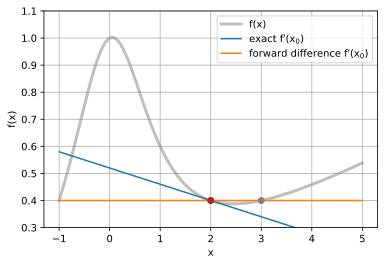

In [4]:
# fix value of h
h = 1

# compute exact tangent function at x0
fp = f0p0 + f0p1*(x-x0)

# function value at x0+h
f_ph = fnk(x0 + h)

# compute difference in function values
# f0p0 is the function (p0) value at x0 (f0)
df_fwd = f_ph - f0p0

# compute line at (x0, f0) with approximated slope
fp_fwd = f0p0 + df_fwd/h*(x-x0)

# plot function f(x)
plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='$\sf f(x)$')

# plot tangent of f(x) at x0
plt.plot(x, fp, color='C0', label="exact $\sf f'(x_0)$")

# plot line at x0, f(x0) with slope computed by forward difference
plt.plot(x, fp_fwd, color='C1', label="forward difference $\sf f'(x_0)$")

# indicate function evaluation points
plt.scatter([x0, x0+h], [f0p0, f_ph], color='grey', zorder=3)
plt.scatter(x0, f0p0, color='firebrick', zorder=3)

plt.ylim(ylim)
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')

plt.savefig('./figs/derivative_forward.svg');
if show: plt.show()
plt.close()

:::{figure-md} fig-fwd-difference

<img src="./figs/derivative_forward.svg" width="90%">

First order forward difference formula.
:::

While the above formula used the value at $\mf x_0 + h$ and is thus called a forward differences formula, it is possible to use the function's value at $\mf x_0 - h$. This results in the backward differences formula

$$
\mf f'(x_0) = \frac{f(x_0) - f(x_0 - h)}{h} + \mathcal{O}(h)\quad .
$$ (eq-fdm-backward-frst)

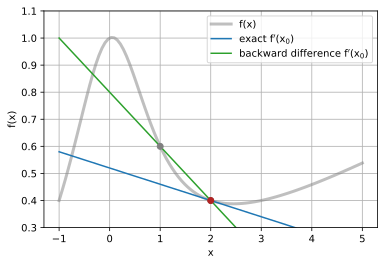

In [5]:
# function value at x0-h
f_nh = fnk(x0 - h)

# compite difference in function values
# f0p0 is the function (p0) value at x0 (f0)
df_bck = f0p0 - f_nh 

# compute line at (x0, f0) with approximated slope
fp_bck = f0p0 + df_bck/h*(x-x0)

# plot function f(x)
plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='$\sf f(x)$')

# plot tangent of f(x) at x0
plt.plot(x, fp, color='C0', label="exact $\sf f'(x_0)$")

# plot line at x0, f(x0) with slope computed by back difference
plt.plot(x, fp_bck, color='C2', label="backward difference $\sf f'(x_0)$")

# indicate function evaluation points
plt.scatter([x0, x0-h], [f0p0, f_nh], color='grey', zorder=3)
plt.scatter(x0, f0p0, color='firebrick', zorder=3)

plt.ylim(ylim)
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')

plt.savefig('./figs/derivative_backward.svg');
if show: plt.show()
plt.close()

:::{figure-md} fig-bck-difference

<img src="./figs/derivative_backward.svg" width="90%">

First order backward difference formula.
:::

First order approximations are mostly not sufficient and higher order approximations are needed. Using more values of the function, i.e. the combination of multiple Taylor series, higher order formula may be derived, like for the second order central differences formula.

The following two Taylor series are used as starting point

$$
\begin{align} 
\mf f(x_0+h) &\mf= f(x_0) + f'(x_0)\cdot h + \frac{1}{2}f''(x_0)\cdot h^2 + \mathcal{O}(h^3) \\ 
\mf f(x_0-h) &\mf= f(x_0) - f'(x_0)\cdot h + \frac{1}{2}f''(x_0)\cdot h^2 + \mathcal{O}(h^3) 
\end{align}
$$ (eq-fdm-central-start)

Subtracting the first equation from the second

$$
\mf f(x_0+h) - f(x_0-h) = 2f'(x_0)\cdot h + \mathcal{O}(h^3)
$$ (eq-fdm-central-intermediate)

results in the central difference formula for the first derivative

$$
\mf f'(x_0) = \frac{f(x_0+h) - f(x_0-h)}{2h} + \mathcal{O}(h^2)\quad .
$$ (eq-cfd-central-derivative-snd)

The central differences formula is graphicaly represented in the following figure.

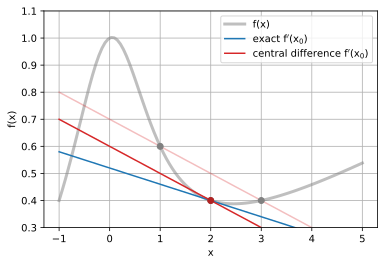

In [6]:
# compite difference in function values
# f0p0 is the function (p0) value at x0 (f0)
df_cnt = f_ph - f_nh

# compute line at (x0, f0) with approximated slope
fp_cnt = f0p0 + df_cnt/(2*h) * (x-x0)
# compute line at (x0+h, f(x0+h)) with approximated slope for illustration
fp_cnt_tmp = f_ph + df_cnt/(2*h) * (x-x0-h)

# plot function f(x)
plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='$\sf f(x)$')

# plot tangent of f(x) at x0
plt.plot(x, fp, color='C0', label="exact $\sf f'(x_0)$")

# plot line at x0, f(x0) with slope computed by central difference
plt.plot(x, fp_cnt, color='C3', label="central difference $\sf f'(x_0)$")
plt.plot(x, fp_cnt_tmp, color='C3', alpha=0.3)

# indicate function evaluation points
plt.scatter([x0-h, x0, x0+h], [f_nh, f0p0, f_ph], color='grey', zorder=3)
plt.scatter(x0, f0p0, color='firebrick', zorder=3)

plt.ylim(ylim)
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')

plt.savefig('./figs/derivative_central.svg');
if show: plt.show()
plt.close()

:::{figure-md} fig-cnt-difference

<img src="./figs/derivative_central.svg" width="90%">

Second order central difference formula.
:::

All three presented methods are shown in a joint illustration in the next figure.

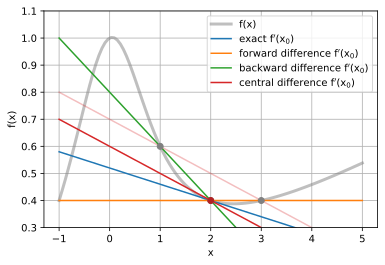

In [7]:
# plot function f(x)
plt.plot(x, f, lw=3, color='grey', alpha=alpha, label='$\sf f(x)$')

# plot tangent of f(x) at x0
plt.plot(x, fp, color='C0', label="exact $\sf f'(x_0)$")

# lines indicating the slope approximations
plt.plot(x, fp_fwd, color='C1', label="forward difference $\sf f'(x_0)$")
plt.plot(x, fp_bck, color='C2', label="backward difference $\sf f'(x_0)$")
plt.plot(x, fp_cnt, color='C3', label="central difference $\sf f'(x_0)$")
plt.plot(x, fp_cnt_tmp, color='C3', alpha=0.3)

# indicate function evaluation points
plt.scatter([x0-h, x0, x0+h], [f_nh, f0p0, f_ph], color='grey', zorder=3)
plt.scatter(x0, f0p0, color='firebrick', zorder=3)

plt.ylim(ylim)
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')

plt.savefig('./figs/derivative_all.svg');
if show: plt.show()
plt.close()

:::{figure-md} fig-all-difference

<img src="./figs/derivative_all.svg" width="90%">

Comparison of all above presented difference formula.
:::

It is also possible to derive directional (forward, backwards) formulas second order. The calculus leads to the follwoing formulas

$$
\begin{align}
\mf f'(x_0) &\mf= \frac{-3f(x_0) + 4f(x_0+h) - f(x_0+2h)}{2h} + \mathcal{O}(h^2) \\
\mf f'(x_0) &\mf= \frac{ 3f(x_0) - 4f(x_0-h) + f(x_0-2h)}{2h} + \mathcal{O}(h^2) \quad .
\end{align}
$$ (eq-cfd-directional-derivative-snd)

```{admonition} Task
Derive the discretisation formula for the second derivative

$$
\mf f''(x_0) = \frac{f(x_0-h) - 2f(x_0) + f(x_0+h)}{h^2} + \mathcal{O}(h^2)
$$ (eq-cfd-central-sndderivative-snd)
```

### Discretisation

In the above section, the derivative of a function was approximated at a single point, here $\mf x_0$. In order to compute the derivative of a function in a given interval $\mf x \in [x_b, x_e]$, a common approach is to discretise the interval. This means, that it is represented by a finite number of points. Given $\mf n_x$ as the number of representing points, the interval becomes the following finite set:

$$
\mf x \in [x_0, \dots, x_i, \dots, x_{n_x-1}]
$$

with

$$ 
\mf x_0 = x_b; \quad x_{n_x-1} = x_e
$$

If the representing points are equally spaced, then the distance $\mf \Delta x$ is

$$
\mf \Delta x = \frac{x_e - x_b}{n_x-1}\quad
$$

and the value of $\mf x_i$ is given by

$$
\mf x_i = x_b + i\cdot \Delta x \quad .
$$

In two and three dimensional cases, this discretisation can be represented as a mesh or grid, see {numref}`fig-field-model`. Thus $\mf \Delta x$ is often called grid spacing.

A common indexing for spatially discretised functions is

$$
\mf f(x_i) = f_i\quad ,
$$

where the index indicating the position on the spatial mesh is placed as a subscript. 

The above definitions and the following examples are for a one-dimensional setup. In general, fire simulations are solved on a three-dimensional domain, with the according quantities for the y- and z-direction, i.e. $\mf \Delta y, \Delta z$.

**Example of a discretisation:** Given $\mf n_x = 20$, the function in equation {eq}`eq-cfd-example-fnk` takes the following discrete representation.

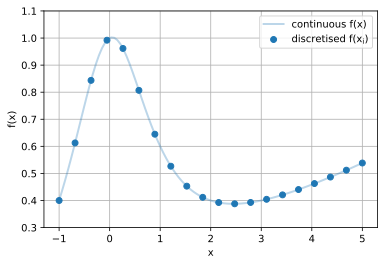

<Figure size 432x288 with 0 Axes>

In [71]:
nx = 20
dx = (xe - xb) / (nx - 1)
xi = np.linspace(xb, xe, nx)

fi = fnk(xi)

plt.plot(x, f, lw=2, color='C0', alpha=0.3, label='continuous $\sf f(x)$')
plt.scatter( xi, fi, color='C0', zorder=5, label='discretised $\sf f(x_i)$')
# plt.vlines( xi, [0] * len(xi), fi, color='grey', alpha=0.3)

# line at y=0
# plt.axhline(0, color='black')

plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(ylim)
plt.savefig('./figs/discretisation.svg')
if show: plt.show()
plt.clf();

:::{figure-md} fig-cfd-discretisation

<img src="./figs/discretisation.svg" width="90%">

One dimensional discretisation.
:::

### Discrete Derivatives

Given the approximation formulas and a discretised function, it becomes possible to compute the function's derivative only with the usage of its values. The approximation formulas are evaluated with $\mf h = \Delta x$. 

For the function shown above and using the central differences second order {eq}`eq-cfd-central-derivative-snd`, plus the directional derivatives {eq}`eq-cfd-directional-derivative-snd` at the boundaries, the approximated derivative is shown in the following figure. 

In [9]:
# function to compute the first derivative with the 
# central differencing scheme
def central(x, y):
    yp = np.zeros_like(y)
    
    for i in range(1, len(x)-1):
        # central discretisation scheme
        yp[i] = (y[i+1] - y[i-1]) / (x[i+1] - x[i-1])
       
    # use of directional derivatives at the boundary
    yp[0]  = (-3*y[ 0] + 4*y[ 1] - y[ 2]) / (x[ 2] - x[ 0])
    yp[-1] = ( 3*y[-1] - 4*y[-2] + y[-3]) / (x[-1] - x[-3])
    
    return yp

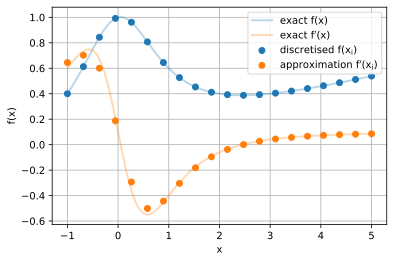

<Figure size 432x288 with 0 Axes>

In [10]:
# analytical solution of the derivative for comparison
fp = fnk(x, derivative=1)

# approximation of the derivative
fpi = central(xi, fi)

# plot of the function
plt.plot(x, f, lw=2, color='C0', alpha=0.3, label='exact $\sf f(x)$')
plt.scatter( xi, fi, color='C0', zorder=5, label='discretised $\sf f(x_i)$')

# plot of the derivative
plt.plot(x, fp, lw=2, color='C1', alpha=0.3, label="exact $\sf f'(x)$")
plt.scatter( xi, fpi, color='C1', zorder=5, label="approximation $\sf f'(x_i)$")

plt.legend()
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
# plt.ylim(ylim)
plt.savefig('./figs/discrete-derivative.svg')
if show: plt.show()
plt.clf();

:::{figure-md} fig-cfd-discrete-derivative

<img src="./figs/discrete-derivative.svg" width="90%">

Approximation of the first derivative.
:::

```{admonition} Task
Create a plot similar to {numref}`fig-cfd-discrete-derivative` for the function

$$
\mf f(x) = x^4 + 3x^3 + 2 \quad .
$$

1. Discretise the function with $\mf n_x = 20$ between -2 and 4 and plot the continouos and discrete representation. 
1. Use this discretasition to approximate the first derivative. Plot the exact and approximated derivative.
1. Do the same for the second derivative.
```

### Approximation Error

If the exact derivative is known, then the exact deviation of the numerical approximation to the exact values can be computed. A common approach to compute the difference between two data sets is the L2-norm or the root mean square error (RMSE). Given the difference of the function values $\mf \Delta f$, here

$$
\mf \Delta f_i = f'_{numeric,i} - f'_{exact,i}
$$

at the same locations $\mf x_i$ with $\mf i \in [0, \dots, n_x-1]$, the RMSE value is 

$$
\mf RMSE(\Delta f) = \sqrt{\frac{1}{n_x}\sum_{i=0}^{n_x-1}\left(\Delta f_i\right)^2}\quad .
$$

For the example function of the previous section, the approximation error can be computed for various values of $\mf \Delta x$, as shown in the following figure. As expected for the second order approximation scheme, the error behaves similar to a quadratic function. However, due to the finite representation of floating point numbers, the convergence stops, when round-off error start to dominate. 


In [63]:
dx_list = []
rmse_list = []
for nxe in range(3, 25):

    nx = 2**nxe
    dx = (xe - xb) / (nx - 1)
    xi = np.linspace(xb, xe, nx)

    fi = fnk(xi)
    fpi = central(xi, fi)
    
    fp = fnk(xi, derivative=1)
    
    rmse = np.sqrt(np.sum((fpi - fp)**2) / nx)
    
    print(f"dx={dx:4.2e} --> rmse={rmse:4.2e}")
    
    dx_list.append(dx)
    rmse_list.append(rmse)
    

dx=8.57e-01 --> rmse=2.12e-01
dx=4.00e-01 --> rmse=4.72e-02
dx=1.94e-01 --> rmse=1.03e-02
dx=9.52e-02 --> rmse=2.55e-03
dx=4.72e-02 --> rmse=6.33e-04
dx=2.35e-02 --> rmse=1.57e-04
dx=1.17e-02 --> rmse=3.92e-05
dx=5.87e-03 --> rmse=9.80e-06
dx=2.93e-03 --> rmse=2.45e-06
dx=1.47e-03 --> rmse=6.12e-07
dx=7.33e-04 --> rmse=1.53e-07
dx=3.66e-04 --> rmse=3.82e-08
dx=1.83e-04 --> rmse=9.55e-09
dx=9.16e-05 --> rmse=2.39e-09
dx=4.58e-05 --> rmse=5.97e-10
dx=2.29e-05 --> rmse=1.49e-10
dx=1.14e-05 --> rmse=3.74e-11
dx=5.72e-06 --> rmse=1.09e-11
dx=2.86e-06 --> rmse=1.14e-11
dx=1.43e-06 --> rmse=1.99e-11
dx=7.15e-07 --> rmse=4.57e-11
dx=3.58e-07 --> rmse=8.91e-11


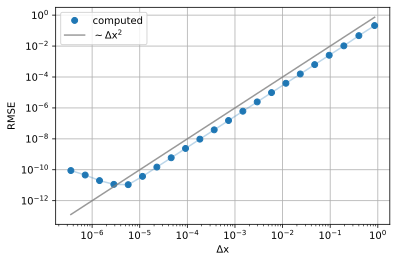

<Figure size 432x288 with 0 Axes>

In [70]:
plt.loglog(dx_list, rmse_list, color='C0', marker='o', linestyle='None', label='computed')
plt.loglog(dx_list, rmse_list, color='C0', alpha=0.3)

dx_np = np.array(dx_list)
plt.loglog(dx_list, dx_np**2, color='grey', alpha=0.8, label='$\sf \sim\Delta x^2$')

plt.grid()
plt.legend()
plt.xlabel("$\sf\Delta x$")
plt.ylabel("$\sf RMSE $")

plt.savefig('./figs/approximation_error.svg')
if show: plt.show()
plt.clf()

:::{figure-md} fig-cfd-approximation-error

<img src="./figs/approximation_error.svg" width="90%">

Approximation error as a function of the mesh spacing.
:::

```{admonition} Task
Why does the approximation error not reduce further for $\mf \Delta x \lesssim 5\cdot 10^{-6}$? Take into account equation {eq}`eq-cfd-central-derivative-snd` and the round off error for 64-bit floating point numbers.
```

## Time Integration

### Trajectories
As the PDEs that are considered in fluid dynamics often contain the time as one dimension, time integration is another aspect besides the spatial derivatives.

In a similar fashion as the spatial discretisation, the time dimension is discretised. Thus, the time interval $\mf [t_b=0, t_e]$ is split into $\mf n_t$ time steps:

$$
\mf t_n = n\cdot\Delta t\quad with \quad \Delta t = \frac{t_e}{n_t-1} \quad and \quad n \in [0, n_t-1]\quad .
$$

In order to distinguish the time index from the spatial index, it is placed as a superscript and is not to be mixed with powers:

$$
\mf u(t_n) = u^n\quad .
$$

Given the time derivative of a function, i.e. the right hand side (rhs),

$$
\mf \partial_t u = \du = rhs(u, t)
$$

and an initial value for $\mf u$ at $\mf t=0$, the temporal evolution, also called trajectory, needs to be computed. Time integration aims to approximate the next value of the solution $\mf u^{n+1}$. 

In the following the evaluation point of rhs is shortened to 

$$
\mf rhs(u(t_n), t_n) = rhs^n \quad .
$$



:::{figure-md} fig-fluid-time-setup

<img src="./figs/time_integration_1_setup.svg" width="80%" >

Time Integration.
:::

### Explicit Euler Method

Based, again on the Tayor series, a direct approximation of the solution's next value is based on 

$$
\mf \frac{u^{n+1} - u^n}{\Delta t} = rhs^n + \mathcal{O}(\Delta t)\quad .
$$ 

It leads directly to

$$
\mf u^{n+1} = u^n + \Delta t \cdot rhs^n + \mathcal{O}(\Delta t)\quad .
$$ (eq-cfd-time-forward-euler)

The equation {eq}`eq-cfd-time-forward-euler` is the explicit / forward Euler method. It is graphicaly demonstrated in {numref}`fig-fluid-time-explicit`.

:::{figure-md} fig-fluid-time-explicit

<img src="./figs/time_integration_2_explicit.svg" width="80%" >

Time integration -- explicit Euler scheme.
:::

### Implicit Euler Method

The evaluation of the derivative in {eq}`eq-cfd-time-forward-euler` at $\mf t_n$ is just one possibility. In the same mannor as the directional spatial derivatives, the evaluation can be done at $\mf t_{n+1}$ and leads to the folowing iteration formula:

$$
\mf u^{n+1} = u^n + \Delta t \cdot rhs^{n+1} + \mathcal{O}(\Delta t)\quad .
$$ (eq-cfd-time-backward-euler)

The equation {eq}`eq-cfd-time-backward-euler` is the implicit / backward Euler method. It is graphicaly demonstrated in {numref}`fig-fluid-time-implicit`. It is an implicit approach, in contrast to the explcit Euler scheme, which does not allow to directly compute the next iteration step based only on the solution of the current values $\mf u^n$. However, as the $\mf rhs$ can be computed for any value of $\mf u$, a matching value of $\mf u^{n+1}$ can be found to satisfy equation {eq}`eq-cfd-time-backward-euler`. 

:::{figure-md} fig-fluid-time-implicit

<img src="./figs/time_integration_3_implicit.svg" width="80%" >

Time integration -- implicit Euler scheme.
:::

<!-- 
### Two Step Method
There is a broad range of time integration methods with various combinations of implicit and explicit sub-steps and approximation orders. In the following sections, three selected examples are presented here. 



:::{figure-md} fig-fluid-time-twostep

<img src="./figs/time_integration_4_twostep.svg" width="80%" >

Time integration -- two step scheme.
::: -->

### Euler-Heun Method

The Euler-Heun method illustrates a second order time integration scheme. 

First, an explicit prediciton is done

$$
\mf u_p^{n+1} = u^n + \Delta t\cdot rhs^n\quad .
$$

This intermediate solution is used for a corrected approximation

$$
\mf u^{n+1} = u^n + \frac{1}{2} \Delta t\cdot \left(rhs^n + rhs(u_p^{n+1}) \right) + \mathcal{O}(\Delta t^2)\quad .
$$


:::{figure-md} fig-fluid-time-predictorcorrector

<img src="./figs/time_integration_5_predictorcorrector.svg" width="80%" >

Time integration -- Euler-Heun predictor-corrector scheme.
:::

### Runge-Kutta method(s)

There exists a wide range of time integration schemes. One class of them are the [Runge-Kutta methods](https://en.wikipedia.org/wiki/Runge–Kutta_methods). The classical scheme is the following fourth order method:

$$
\begin{align} 
\mf u^{(1)} &=\mf u^n + \frac{1}{2}\Delta t\cdot rhs^n \\ 
\mf u^{(2)} &=\mf u^n + \frac{1}{2}\Delta t\cdot rhs\left(u^{(1)}\right) \\ 
\mf u^{(3)} &=\mf u^n + \Delta t\cdot rhs\left(u^{(2)}\right) \\ 
\mf u^{n+1} &=\mf u^n + \frac{1}{6}\Delta t\cdot \left(rhs^n + 2\ rhs\left(u^{(1)}\right) + 2\ rhs\left(u^{(2)}\right) + rhs\left(u^{(3)}\right)\right) + \mathcal{O}(\Delta t^4) \quad .
\end{align}
$$


<!-- ## Finite Difference Method

### Scheme
 -->

## Finite Difference Method

### Solution Approach

Consider a simple diffusion equation:

$$
\mf \partial_t \phi = \lambda\partial_{xx} \phi
$$ 

**Forward Euler:** This scheme can be directly -- explicitly -- evaluated.

$$
\mf \frac{\phi^{n+1}_i - \phi^n_i}{\Delta t} = \lambda\frac{\phi^n_{i-1} - 2\phi_i^n + \phi_{i+1}^n}{\Delta x^2}
$$

$$
\mf \phi^{n+1}_i = \phi^n_i + \Delta t \lambda \frac{\phi^n_{i-1} - 2\phi_i^n + \phi_{i+1}^n}{\Delta x^2}
$$

:::{figure-md} fig-fdm-explicit-euler

<img src="./figs/fdm_explicit_euler.png" width="80%" >

Explicit Euler scheme.
:::


**Backward Euler:** Here a linear equation system must be solved for $\phi^{n+1}$." 

$$
\mf \frac{\phi^{n+1}_i - \phi^n_i}{\Delta t} = \lambda \frac{\phi^{n+1}_{i-1} - 2\phi_i^{n+1} + \phi_{i+1}^{n+1}}{\Delta x^2}
$$

$$
\mf \phi^{n+1}_i - \frac{\Delta t}{\Delta x^2}\lambda\left( \phi^{n+1}_{i-1} - 2\phi_i^{n+1} + \phi_{i+1}^{n+1} \right) = \phi^n_i
$$

$$
\mf A\phi^{n+1} = \phi^n
$$

:::{figure-md} fig-fdm-implicit-euler

<img src="./figs/fdm_implicit_euler.png" width="80%" >

Implicit Euler scheme.
:::

## Stability

### Information Propagation
An important property of a time integrator is its stability. Given a PDE to be solved and a time integrator, a simple (linear) stability analysis can be conducted, e.g. von Neuman stability analysis. The outcome is the growth factor, which indicates the growth rate of small disturbances. If this factor is larger then 1, then the scheme is unstable, as fluctuations will infinitely rise.

* Explicit schemes tend to be unstable or conditionally stable, i.e. if a condition for the time step is met
* Implicit schemes tend to be unconditionally stable, however they tend to damp the solution

A constant velocity advection problem demonstrates the stability condition.

**Slow propagation speed**

* Model equation
  
  $$
  \mf \partial_t \phi + \partial_x(v_0\phi) = 0
  $$
* Small $\mf \Delta t$ 
* Distance traveled per $\mf \Delta t$:
  
  $$
  \mf \delta x = v_0 \Delta t \lt \Delta x
  $$
* The information moves less then $\mf\Delta x$ in a time step $\mf\Delta t$ and is captured by the neighbouring grid point
* No solution information is lost during time integration

:::{figure-md} fig-fdm-cfl-dtsmall

<img src="./figs/fdm_cfl_dtsmall.png" width="80%" >

Slow information propagation.
:::

**Fast propagation speed**

* Large $\mf\Delta t$
* Distance traveled per $\mf\Delta t$:

  $$
  \mf \delta x = v_0 \Delta t \gt \Delta x
  $$
* The information moves more then $\mf \Delta x$ in a time step $\mf\Delta t$ and can therefore not be captured anymore
* Information is lost during time integration

:::{figure-md} fig-fdm-cfl-dtlarge

<img src="./figs/fdm_cfl_dtlarge.png" width="80%" >

Fast information propagation.
:::

### Courant-Friedrichs-Lewy (CFL) condition

In general, there exist stability conditions for explicit schemes, which relates the maximal information travel speed $\mf v_{max}$ and the grid velocity $\mf v_g = \Delta x / \Delta t$:

$$
\mf v_{max} \lt CFL\cdot v_{g}\quad .
$$

Given a mesh resolution $\mf\Delta x$ and maximal velocities, the above condition limits the time step:

$$
\mf \Delta t \lt CFL\cdot \frac{\Delta x}{v_{max}}
$$

Notes:
* The flow velocity may be computed in various ways ($\mf L_\infty$, $L_1$, $L_2$ norms), diffusion velocity $\mf \propto 1/\Delta x$
* There also exist other constrains on $\mf Delta t$: mass density constraint and volume constraint.
* The value of the CFL number depends on the time integration scheme.

Implications of the CFL condition in FDS:

The condition for $\mf \Delta t$ used in FDS is

$$
\mf 0.8 \leq CFL = \Delta t \left(\frac{\|\vec{v}\|}{\Delta x} + |\nabla \cdot \vec{v}|\right) \leq 1.0
$$

* If the CFL number grows above the upper limit, the time step is set to 90% of the allowed, if it falls below the lower limit, then it is increased by 10%.
* In general, the time step is reduced by a factor of 2 when the mesh spacing is reduced by a factor of 2, i.e. the total computational effort increases by a factor of 16.

### Side note on how computation was performed in the past

Short section from Richard Feynmans presentation "Los Alamos from Below". He describes how numerical calculations were performed by individual people per grid node and type of computation.

<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/uY-u1qyRM5w?start=2804" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>